<a href="https://colab.research.google.com/github/hannesstuehrenberg/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/08-1SHXXXX_football_analytics/projects/08-1SHXXXX_football_analytics/notebooks/05_model_training_and_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mplsoccer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.4/86.4 kB 2.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from mplsoccer import VerticalPitch
from mplsoccer import Sbopen
from tqdm import tqdm
import gdown

import warnings
warnings.filterwarnings('ignore')

parser = Sbopen()


5. Model Training and Evaluation

* Training process
* Model evaluation (metrics, plots, performance)
* Cross-validation or uncertainty quantification


In [4]:
file_id = '1_WstcnGf_tUzWBj8XTN104EOkFlF5UN_'
url = f'https://drive.google.com/uc?id={file_id}'
shots_master_df = pd.read_csv(url)

print(shots_master_df.shape)

(79966, 67)


In [5]:
shots_master_df = shots_master_df.drop_duplicates()

print(shots_master_df.shape)

(79862, 67)


In [6]:
shots_master_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79862 entries, 0 to 79965
Data columns (total 67 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           79862 non-null  object 
 1   index                        79862 non-null  int64  
 2   match_id                     79862 non-null  int64  
 3   period                       79862 non-null  int64  
 4   timestamp                    79862 non-null  object 
 5   team_id                      79862 non-null  int64  
 6   team_name                    79862 non-null  object 
 7   player_id                    79862 non-null  float64
 8   player_name                  79862 non-null  object 
 9   position_id                  79862 non-null  float64
 10  position_name                79862 non-null  object 
 11  x                            79862 non-null  float64
 12  y                            79862 non-null  float64
 13  end_x                

In [7]:
feature_columns = [
    'distance_to_goal',
    'angle_to_goal_deg',
    'opponents_in_way',
    'teammates_in_way',
    'with_dominant_foot',
    'shot_first_time',
    'shot_one_on_one',
    'shot_open_goal',
    'technique_Backheel',
    'technique_Diving Header',
    'technique_Half Volley',
    'technique_Lob',
    'technique_Normal',
    'technique_Overhead Kick',
    'technique_Volley',
    'subtype_Free Kick',
    'subtype_Open Play',
    'subtype_Penalty',
    'is_header'
]

from sklearn.model_selection import train_test_split

X = shots_master_df[feature_columns]
y = shots_master_df['goal']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

print("\nGoal distribution in training set:")
print(y_train.value_counts(normalize=True))

print("\nGoal distribution in test set:")
print(y_test.value_counts(normalize=True))




Training set size: 63889 samples
Test set size: 15973 samples

Goal distribution in training set:
goal
0    0.888087
1    0.111913
Name: proportion, dtype: float64

Goal distribution in test set:
goal
0    0.888124
1    0.111876
Name: proportion, dtype: float64


In [8]:
numerical_features = [
    'distance_to_goal',
    'angle_to_goal_deg',
    'opponents_in_way',
    'teammates_in_way',
    'with_dominant_foot'
]

binary_features = [
    'shot_first_time',
    'shot_one_on_one',
    'shot_open_goal',
    'technique_Backheel',
    'technique_Diving Header',
    'technique_Half Volley',
    'technique_Lob',
    'technique_Normal',
    'technique_Overhead Kick',
    'technique_Volley',
    'subtype_Free Kick',
    'subtype_Open Play',
    'subtype_Penalty',
    'is_header'
]

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('bin', 'passthrough', binary_features)
    ]
)


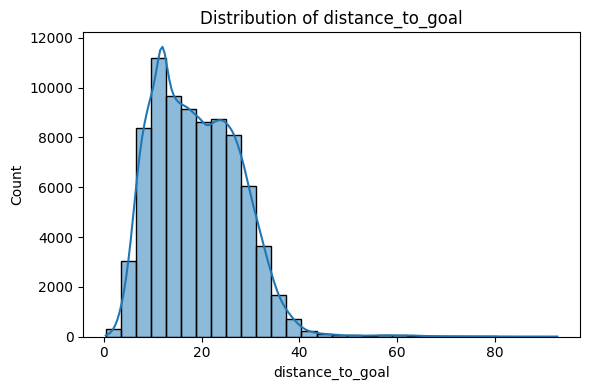

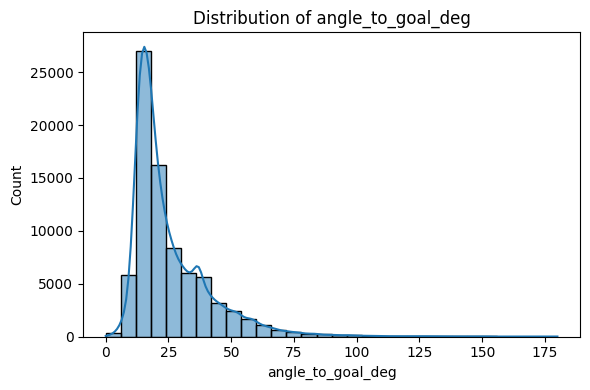

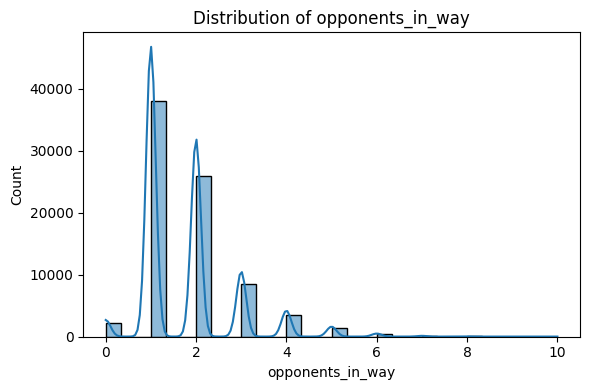

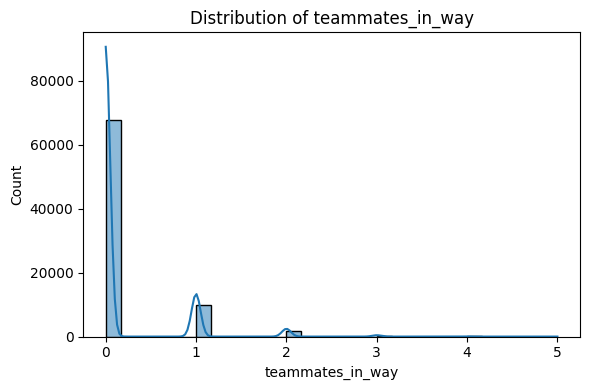

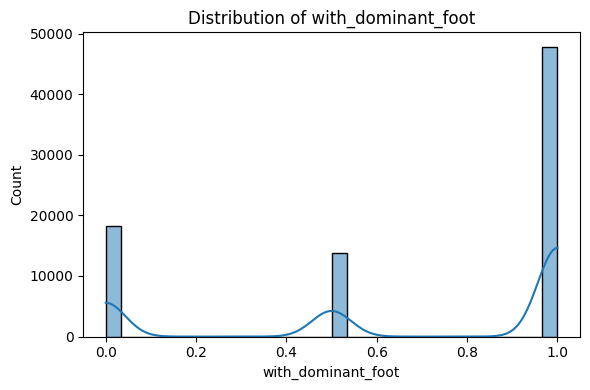

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in numerical_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(shots_master_df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


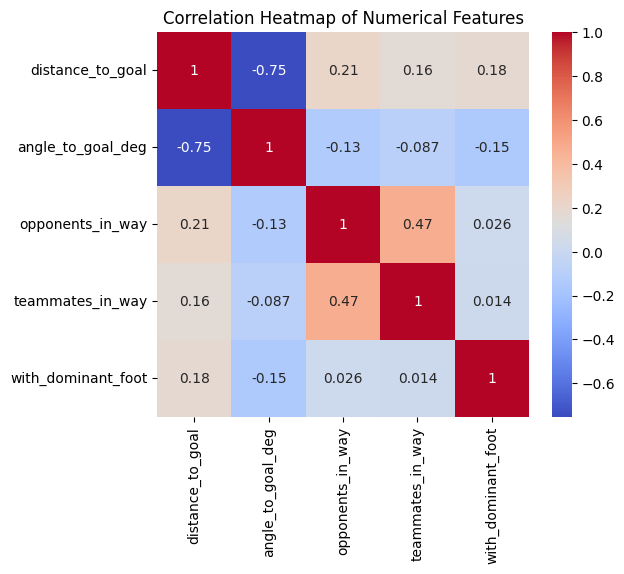

In [10]:
corr = shots_master_df[numerical_features].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

In [11]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X_num = shots_master_df[numerical_features]

X_num_const = sm.add_constant(X_num)

In [12]:
import statsmodels.api as sm

vif_data = pd.DataFrame()
vif_data["Feature"] = X_num.columns
vif_data["VIF"] = [variance_inflation_factor(X_num.values, i) for i in range(X_num.shape[1])]

print(vif_data)

              Feature       VIF
0    distance_to_goal  4.581543
1   angle_to_goal_deg  2.315673
2    opponents_in_way  4.805525
3    teammates_in_way  1.457450
4  with_dominant_foot  3.648898


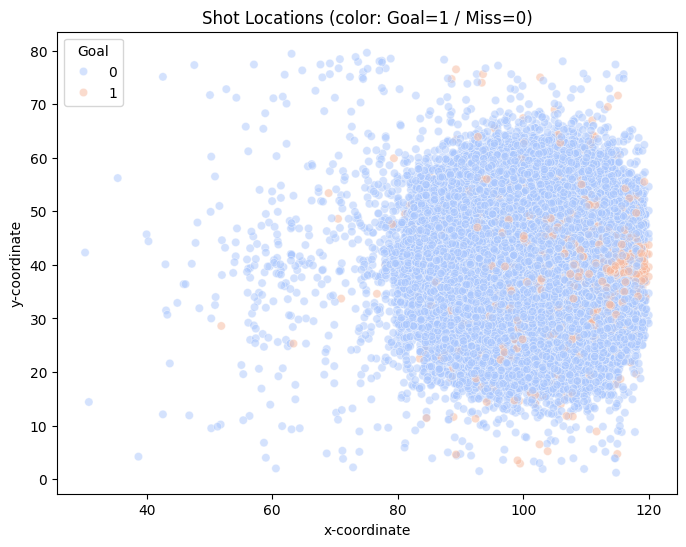

In [13]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=shots_master_df,
    x='x', y='y',
    hue='goal',
    palette='coolwarm',
    alpha=0.5
)
plt.title("Shot Locations (color: Goal=1 / Miss=0)")
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")
plt.legend(title='Goal')
plt.show()

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

pipeline_logistic = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        max_iter=1000,
        solver='lbfgs',
        class_weight='balanced',
        random_state=42
    ))
])

In [15]:
pipeline_logistic.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['distance_to_goal',
                                                   'angle_to_goal_deg',
                                                   'opponents_in_way',
                                                   'teammates_in_way',
                                                   'with_dominant_foot']),
                                                 ('bin', 'passthrough',
                                                  ['shot_first_time',
                                                   'shot_one_on_one',
                                                   'shot_open_goal',
                                                   'technique_Backheel',
                                                   'technique_Diving Header',
                                                   'technique_Half Volley',
                                                   'technique_Lob',
                                                   'technique_Normal',
                                                   'technique_Overhead Kick',
                                                   'technique_Volley',
                                                   'subtype_Free Kick',
                                                   'subtype_Open Play',
                                                   'subtype_Penalty',
                                                   'is_header'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [16]:
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss

y_pred_proba = pipeline_logistic.predict_proba(X_test)[:, 1]

#Predict class labels with default threshold 0.5
y_pred = pipeline_logistic.predict(X_test)

In [17]:
y_pred = pipeline_logistic.predict(X_test)
y_pred_proba = pipeline_logistic.predict_proba(X_test)[:, 1]

#Metrics:
auc = roc_auc_score(y_test, y_pred_proba)
acc = accuracy_score(y_test, y_pred)
ll = log_loss(y_test, y_pred_proba)

print(f"AUC: {auc:.3f}")
print(f"Accuracy: {acc:.3f}")
print(f"Log-Loss: {ll:.3f}")

AUC: 0.807
Accuracy: 0.761
Log-Loss: 0.523


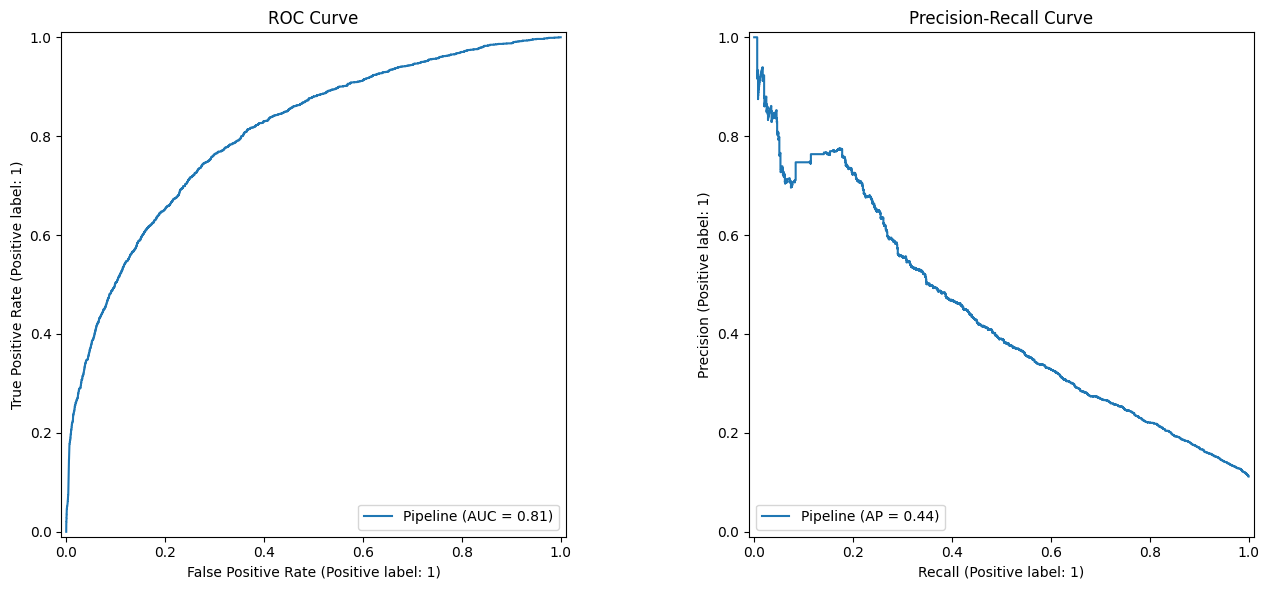

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

roc_display = RocCurveDisplay.from_estimator(pipeline_logistic, X_test, y_test, ax=axes[0])
axes[0].set_title("ROC Curve")

pr_display = PrecisionRecallDisplay.from_estimator(pipeline_logistic, X_test, y_test, ax=axes[1])
axes[1].set_title("Precision-Recall Curve")

plt.tight_layout()
plt.show()

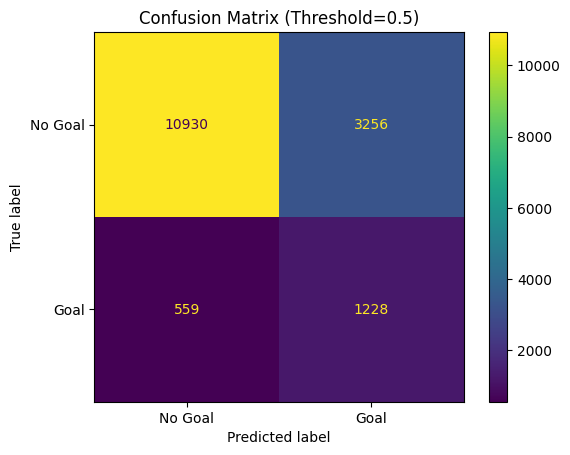

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["No Goal", "Goal"]).plot(values_format='d')
plt.title("Confusion Matrix (Threshold=0.5)")
plt.show()


In [20]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.arange(0.0, 1.01, 0.05)
precisions, recalls, f1s = [], [], []

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    precisions.append(precision_score(y_test, y_pred_thresh, zero_division=0))
    recalls.append(recall_score(y_test, y_pred_thresh, zero_division=0))
    f1s.append(f1_score(y_test, y_pred_thresh, zero_division=0))

optimal_idx = np.argmax(f1s)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.2f}")
print(f"Precision at optimal threshold: {precisions[optimal_idx]:.3f}")
print(f"Recall at optimal threshold: {recalls[optimal_idx]:.3f}")
print(f"F1 at optimal threshold: {f1s[optimal_idx]:.3f}")


Optimal threshold: 0.70
Precision at optimal threshold: 0.447
Recall at optimal threshold: 0.432
F1 at optimal threshold: 0.439


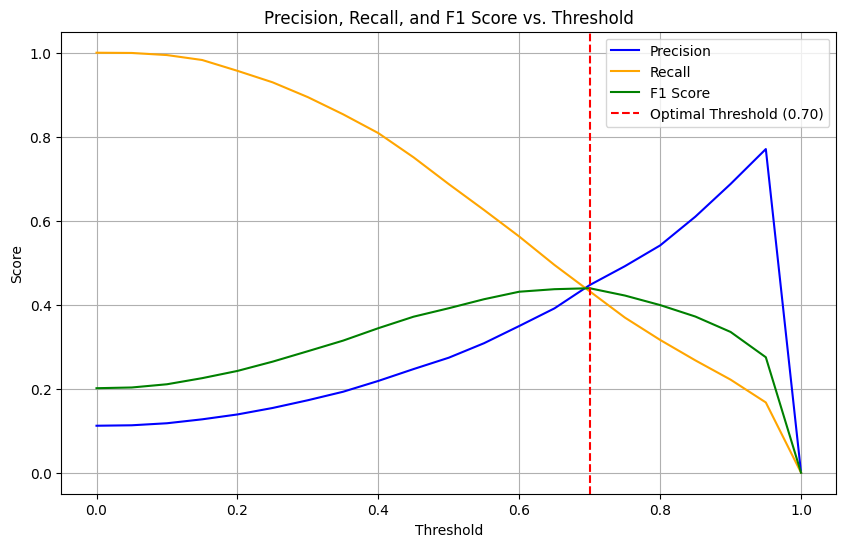

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='orange')
plt.plot(thresholds, f1s, label='F1 Score', color='green')
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()


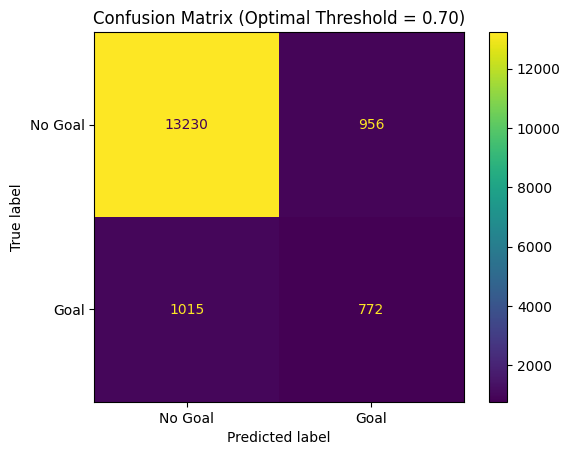

In [22]:
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_optimal)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Goal", "Goal"])
disp.plot(values_format='d')
plt.title(f"Confusion Matrix (Optimal Threshold = {optimal_threshold:.2f})")
plt.show()


In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score

final_precision = precision_score(y_test, y_pred_optimal, zero_division=0)
final_recall = recall_score(y_test, y_pred_optimal, zero_division=0)
final_f1 = f1_score(y_test, y_pred_optimal, zero_division=0)

print(f"Final Precision: {final_precision:.3f}")
print(f"Final Recall: {final_recall:.3f}")
print(f"Final F1 Score: {final_f1:.3f}")

Final Precision: 0.447
Final Recall: 0.432
Final F1 Score: 0.439


In [24]:
num_features_scaled = numerical_features
bin_features = binary_features

all_features = num_features_scaled + bin_features


In [25]:
import pandas as pd

coefficients = pipeline_logistic.named_steps['classifier'].coef_[0]

coef_df = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

print(coef_df)


                    Feature  Coefficient
11            technique_Lob     1.705519
9   technique_Diving Header     1.065646
17          subtype_Penalty     0.953943
7            shot_open_goal     0.773606
1         angle_to_goal_deg     0.526426
15        subtype_Free Kick     0.510365
6           shot_one_on_one     0.473324
12         technique_Normal     0.316125
5           shot_first_time     0.119083
4        with_dominant_foot     0.030745
3          teammates_in_way    -0.001415
10    technique_Half Volley    -0.192558
14         technique_Volley    -0.327990
2          opponents_in_way    -0.359868
13  technique_Overhead Kick    -0.807609
0          distance_to_goal    -0.820717
16        subtype_Open Play    -1.054239
8        technique_Backheel    -1.349063
18                is_header    -1.593817


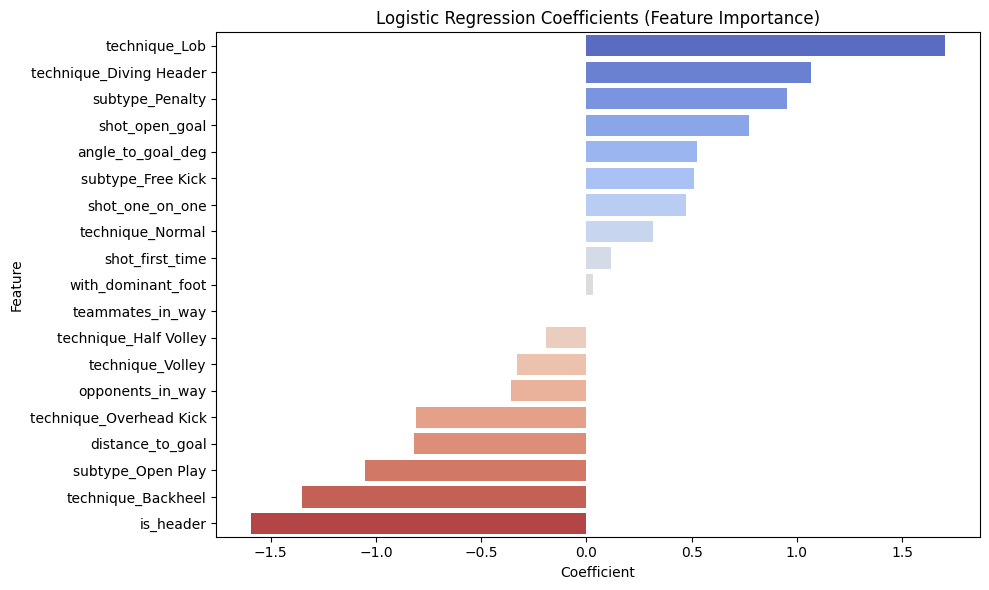

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df, x='Coefficient', y='Feature', palette='coolwarm')
plt.title("Logistic Regression Coefficients (Feature Importance)")
plt.tight_layout()
plt.show()


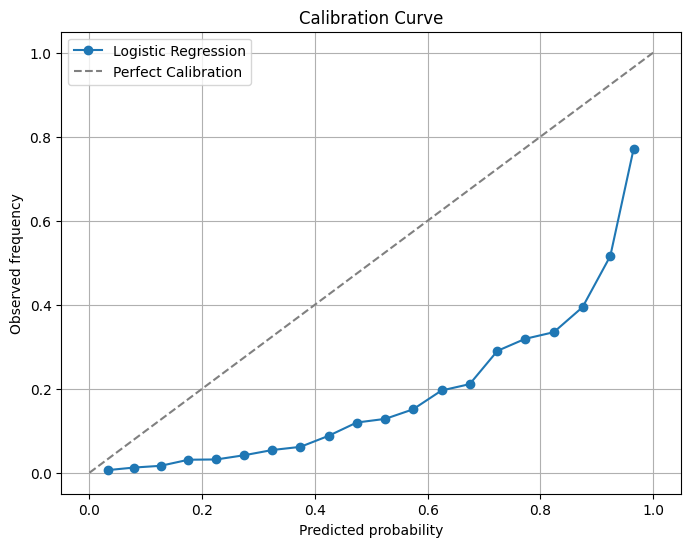

In [73]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=20, strategy='uniform')

plt.figure(figsize=(8,6))
plt.plot(prob_pred, prob_true, marker='o', label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Predicted probability')
plt.ylabel('Observed frequency')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()


In [74]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_pipeline_logistic = CalibratedClassifierCV(
    estimator=pipeline_logistic,
    method='sigmoid',
    cv=5
)

calibrated_pipeline_logistic.fit(X_train, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=Pipeline(steps=[('preprocessor',
                                                  ColumnTransformer(transformers=[('num',
                                                                                   StandardScaler(),
                                                                                   ['distance_to_goal',
                                                                                    'angle_to_goal_deg',
                                                                                    'opponents_in_way',
                                                                                    'teammates_in_way',
                                                                                    'with_dominant_foot']),
                                                                                  ('bin',
                                                                                   'passthrough',
                                                                                   ['shot_first_time',
                                                                                    'shot_one_on_one',
                                                                                    'shot_open_goal',
                                                                                    'technique_Backheel',
                                                                                    'technique_Diving '
                                                                                    'Header',
                                                                                    'technique_Half '
                                                                                    'Volley',
                                                                                    'technique_Lob',
                                                                                    'technique_Normal',
                                                                                    'technique_Overhead '
                                                                                    'Kick',
                                                                                    'technique_Volley',
                                                                                    'subtype_Free '
                                                                                    'Kick',
                                                                                    'subtype_Open '
                                                                                    'Play',
                                                                                    'subtype_Penalty',
                                                                                    'is_header'])])),
                                                 ('classifier',
                                                  LogisticRegression(class_weight='balanced',
                                                                     max_iter=1000,
                                                                     random_state=42))]))

In [75]:
y_pred_proba_calibrated = calibrated_pipeline_logistic.predict_proba(X_test)[:, 1]

from sklearn.metrics import roc_auc_score, log_loss

auc_cal = roc_auc_score(y_test, y_pred_proba_calibrated)
ll_cal = log_loss(y_test, y_pred_proba_calibrated)

print(f"Calibrated AUC: {auc_cal:.3f}")
print(f"Calibrated Log-Loss: {ll_cal:.3f}")


Calibrated AUC: 0.807
Calibrated Log-Loss: 0.278


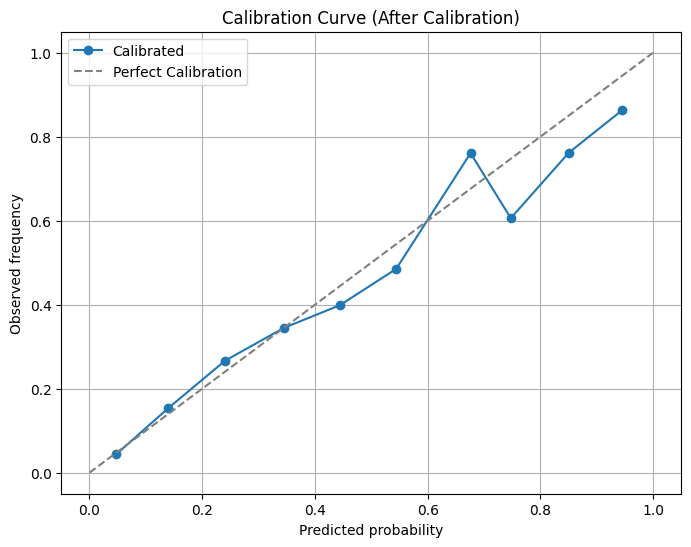

In [76]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_true_cal, prob_pred_cal = calibration_curve(y_test, y_pred_proba_calibrated, n_bins=10)

plt.figure(figsize=(8,6))
plt.plot(prob_pred_cal, prob_true_cal, marker='o', label='Calibrated')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Predicted probability')
plt.ylabel('Observed frequency')
plt.title('Calibration Curve (After Calibration)')
plt.legend()
plt.grid(True)
plt.show()


In [77]:
lr_probs_before = pipeline_logistic.predict_proba(X_test)[:, 1]

lr_probs_after = calibrated_pipeline_logistic.predict_proba(X_test)[:, 1]

In [69]:
from sklearn.metrics import (
    roc_auc_score, accuracy_score, log_loss, brier_score_loss, average_precision_score
)

#Before calibration
y_pred = pipeline_logistic.predict(X_test)
y_pred_proba = pipeline_logistic.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_pred_proba)
acc = accuracy_score(y_test, y_pred)
ll = log_loss(y_test, y_pred_proba)
brier = brier_score_loss(y_test, y_pred_proba)
ap = average_precision_score(y_test, y_pred_proba)

print("Before calibration:")
print(f"AUC:       {auc:.3f}")
print(f"Accuracy:  {acc:.3f}")
print(f"Log-Loss:  {ll:.3f}")
print(f"Brier:     {brier:.3f}")
print(f"AP:        {ap:.3f}")

#After calibration
y_pred_cal = calibrated_pipeline_logistic.predict(X_test)
y_pred_proba_cal = calibrated_pipeline_logistic.predict_proba(X_test)[:, 1]

auc_cal = roc_auc_score(y_test, y_pred_proba_cal)
acc_cal = accuracy_score(y_test, y_pred_cal)
ll_cal = log_loss(y_test, y_pred_proba_cal)
brier_cal = brier_score_loss(y_test, y_pred_proba_cal)
ap_cal = average_precision_score(y_test, y_pred_proba_cal)

print("\nAfter calibration:")
print(f"AUC:       {auc_cal:.3f}")
print(f"Accuracy:  {acc_cal:.3f}")
print(f"Log-Loss:  {ll_cal:.3f}")
print(f"Brier:     {brier_cal:.3f}")
print(f"AP:        {ap_cal:.3f}")


Before calibration:
AUC:       0.807
Accuracy:  0.761
Log-Loss:  0.523
Brier:     0.170
AP:        0.439

After calibration:
AUC:       0.807
Accuracy:  0.901
Log-Loss:  0.278
Brier:     0.080
AP:        0.439


In [36]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_scores = cross_val_score(
    calibrated_pipeline_logistic, X_train, y_train,
    cv=cv, scoring='roc_auc', n_jobs=-1
)

logloss_scores = cross_val_score(
    calibrated_pipeline_logistic, X_train, y_train,
    cv=cv, scoring='neg_log_loss', n_jobs=-1
)

logloss_scores = -logloss_scores

print(f"Cross-validated AUC: mean={auc_scores.mean():.3f}, std={auc_scores.std():.3f}")
print(f"Cross-validated Log-Loss: mean={logloss_scores.mean():.3f}, std={logloss_scores.std():.3f}")

cv_results = pd.DataFrame({
    'AUC': auc_scores,
    'Log-Loss': logloss_scores
})

print(cv_results)

Cross-validated AUC: mean=0.809, std=0.003
Cross-validated Log-Loss: mean=0.278, std=0.002
        AUC  Log-Loss
0  0.810310  0.278375
1  0.809269  0.279013
2  0.809510  0.275792
3  0.813868  0.275637
4  0.804186  0.278977


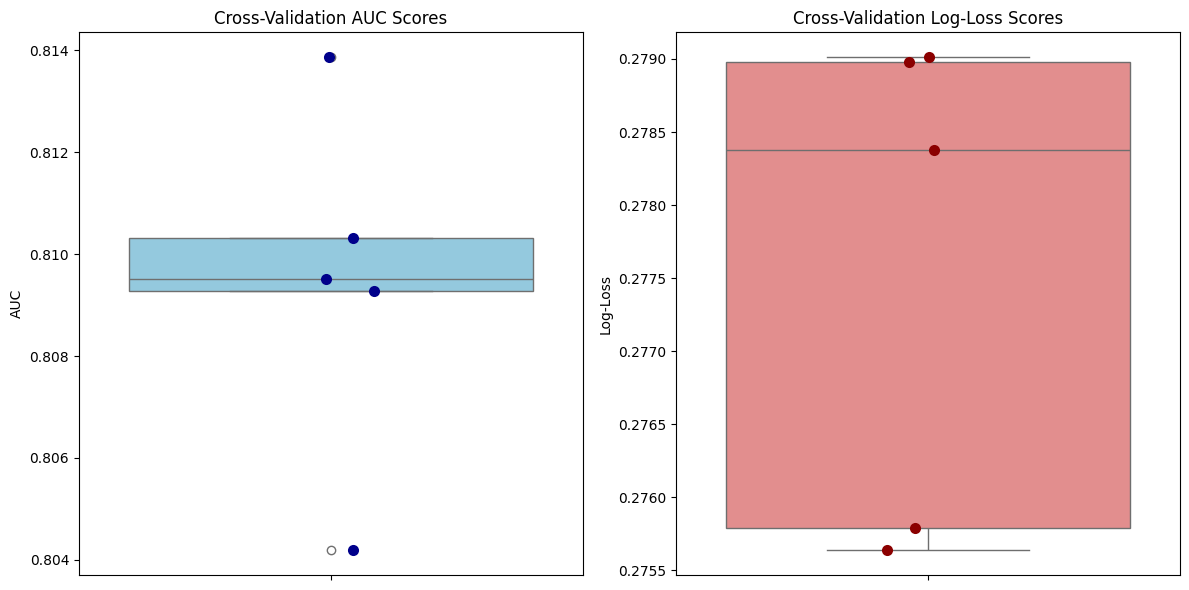

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(y=cv_results['AUC'], color='skyblue')
sns.stripplot(y=cv_results['AUC'], color='darkblue', jitter=0.1, size=8)
plt.title('Cross-Validation AUC Scores')
plt.ylabel('AUC')

plt.subplot(1, 2, 2)
sns.boxplot(y=cv_results['Log-Loss'], color='lightcoral')
sns.stripplot(y=cv_results['Log-Loss'], color='darkred', jitter=0.1, size=8)
plt.title('Cross-Validation Log-Loss Scores')
plt.ylabel('Log-Loss')

plt.tight_layout()
plt.show()


Bayesian Logistic Regression

In [27]:
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

In [ ]:
import pymc as pm
import numpy as np
import arviz as az

from google.colab import drive
drive.mount('/content/drive')

X_train_bayes = X_train_scaled.astype(np.float32)
X_test_bayes = X_test_scaled.astype(np.float32)
y_train_bayes = y_train.values.astype(np.int32)

n_features = X_train_bayes.shape[1]

with pm.Model() as bayesian_logreg:
    intercept = pm.Normal("intercept", mu=0, sigma=5)
    coeffs = pm.Normal("coeffs", mu=0, sigma=5, shape=n_features)
    linear_combination = intercept + pm.math.dot(X_train_bayes, coeffs)
    p = pm.Deterministic("p", pm.math.sigmoid(linear_combination))
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_train_bayes)
    trace = pm.sample(draws=1000, tune=1000, target_accept=0.9, cores=2, return_inferencedata=True)

print(az.summary(trace, var_names=["intercept", "coeffs"], hdi_prob=0.95))

drive_path = "/content/drive/MyDrive/bayesian_logreg_trace.nc"
az.to_netcdf(trace, drive_path)
print(f"Trace saved to {drive_path} successfully!")

from google.colab import files
files.download(drive_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


             mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
intercept  -0.703  2.915    -6.055      4.544      0.232    0.139     161.0   
coeffs[0]  -0.888  0.034    -0.957     -0.828      0.002    0.002     452.0   
coeffs[1]   0.413  0.022     0.375      0.455      0.001    0.001     482.0   
coeffs[2]  -0.425  0.022    -0.465     -0.384      0.001    0.001     619.0   
coeffs[3]   0.015  0.022    -0.025      0.057      0.001    0.001     897.0   
coeffs[4]   0.025  0.013     0.002      0.048      0.000    0.001    1039.0   
coeffs[5]   0.075  0.040    -0.011      0.142      0.002    0.002     534.0   
coeffs[6]   0.279  0.051     0.185      0.381      0.002    0.002     561.0   
coeffs[7]   0.804  0.102     0.602      0.992      0.004    0.004     517.0   
coeffs[8]  -1.460  1.787    -4.622      2.116      0.163    0.092     120.0   
coeffs[9]   0.834  1.784    -2.306      4.460      0.161    0.092     121.0   
coeffs[10] -0.407  1.782    -3.434      3.320      0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [41]:
!pip install gdown
import gdown
import arviz as az

file_id_blr = '1FJ-9Wbuy9ugk8xMNOjHViTGO2PQ65EIt'
gdown.download(f'https://drive.google.com/uc?id={file_id_blr}', 'blr_model.nc', quiet=False)

idata = az.from_netcdf('blr_model.nc')

print(idata)
print(az.summary(idata, var_names=["intercept","coeffs"], hdi_prob=0.95))

Downloading...
From (original): https://drive.google.com/uc?id=1FJ-9Wbuy9ugk8xMNOjHViTGO2PQ65EIt
From (redirected): https://drive.google.com/uc?id=1FJ-9Wbuy9ugk8xMNOjHViTGO2PQ65EIt&confirm=t&uuid=4198316f-d835-4baa-9b58-38e41c0ac4fe
To: /content/blr_model.nc
100%|██████████| 963M/963M [00:13<00:00, 69.9MB/s]


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
             mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
intercept  -0.809  2.779    -6.070      4.781      0.110    0.069     650.0   
coeffs[0]  -0.890  0.033    -0.956     -0.829      0.001    0.001    1621.0   
coeffs[1]   0.412  0.021     0.369      0.455      0.000    0.000    1902.0   
coeffs[2]  -0.426  0.021    -0.465     -0.384      0.000    0.000    2859.0   
coeffs[3]   0.016  0.020    -0.021      0.055      0.000    0.000    2435.0   
coeffs[4]   0.025  0.015    -0.004      0.052      0.000    0.000    2291.0   
coeffs[5]   0.074  0.038    -0.005      0.148      0.001    0.001    2151.0   
coeffs[6]   0.274  0.051     0.167      0.367      0.001    0.001    2063.0   
coeffs[7]   0.804  0.102     0.596      0.993      0.002    0.003    2709.0   
coeffs[8]  -1.448  1.834    -4.930      2.086      0.099    0.048     338.0   
coeffs[9]   0.843  1.834    -2.428      4.607      0.101 

In [42]:
import numpy as np
from scipy.special import expit

intercept_samples = idata.posterior["intercept"].stack(samples=("chain", "draw")).values
coeff_samples     = idata.posterior["coeffs"].stack(samples=("chain", "draw")).values

X_test_bayes = X_test_scaled.astype(np.float32)

intercept_samples_2d = intercept_samples[:, np.newaxis]

linpreds = intercept_samples_2d + np.dot(coeff_samples.T, X_test_bayes.T)

probs = expit(linpreds)

mean_probs = probs.mean(axis=0)

y_hat = (mean_probs >= 0.5).astype(np.int32)

print("First 100 predicted probabilities:", mean_probs[:20])
print("First 100 predicted classes:", y_hat[:20])


First 100 predicted probabilities: [0.01282631 0.11236571 0.06948641 0.00888656 0.09825448 0.07834883
 0.06867037 0.01587832 0.00222853 0.09817717 0.02145794 0.15104349
 0.02785349 0.19633197 0.03420854 0.01483913 0.07046822 0.3233164
 0.09599357 0.16915757]
First 100 predicted classes: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [43]:
lower = np.percentile(probs, 2.5, axis=0)
upper = np.percentile(probs, 97.5, axis=0)

for i in range(20):
    print(f"Point {i}: mean={mean_probs[i]:.3f}, 95% CI=({lower[i]:.3f}, {upper[i]:.3f})")


Point 0: mean=0.013, 95% CI=(0.012, 0.014)
Point 1: mean=0.112, 95% CI=(0.105, 0.120)
Point 2: mean=0.069, 95% CI=(0.066, 0.074)
Point 3: mean=0.009, 95% CI=(0.008, 0.010)
Point 4: mean=0.098, 95% CI=(0.090, 0.106)
Point 5: mean=0.078, 95% CI=(0.074, 0.083)
Point 6: mean=0.069, 95% CI=(0.064, 0.073)
Point 7: mean=0.016, 95% CI=(0.014, 0.018)
Point 8: mean=0.002, 95% CI=(0.002, 0.003)
Point 9: mean=0.098, 95% CI=(0.090, 0.107)
Point 10: mean=0.021, 95% CI=(0.019, 0.024)
Point 11: mean=0.151, 95% CI=(0.123, 0.184)
Point 12: mean=0.028, 95% CI=(0.025, 0.031)
Point 13: mean=0.196, 95% CI=(0.184, 0.208)
Point 14: mean=0.034, 95% CI=(0.031, 0.038)
Point 15: mean=0.015, 95% CI=(0.013, 0.017)
Point 16: mean=0.070, 95% CI=(0.067, 0.074)
Point 17: mean=0.323, 95% CI=(0.308, 0.339)
Point 18: mean=0.096, 95% CI=(0.088, 0.105)
Point 19: mean=0.169, 95% CI=(0.156, 0.183)


In [44]:
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, brier_score_loss, average_precision_score
import numpy as np


y_pred = (mean_probs >= 0.5).astype(int)

auc = roc_auc_score(y_test, mean_probs)
acc = accuracy_score(y_test, y_pred)
ll = log_loss(y_test, mean_probs)
brier = brier_score_loss(y_test, mean_probs)
ap = average_precision_score(y_test, mean_probs)

print("Before calibration:")
print(f"AUC:       {auc:.3f}")
print(f"Accuracy:  {acc:.3f}")
print(f"Log-Loss:  {ll:.3f}")
print(f"Brier:     {brier:.3f}")
print(f"AP:        {ap:.3f}")


Before calibration:
AUC:       0.805
Accuracy:  0.902
Log-Loss:  0.277
Brier:     0.079
AP:        0.442


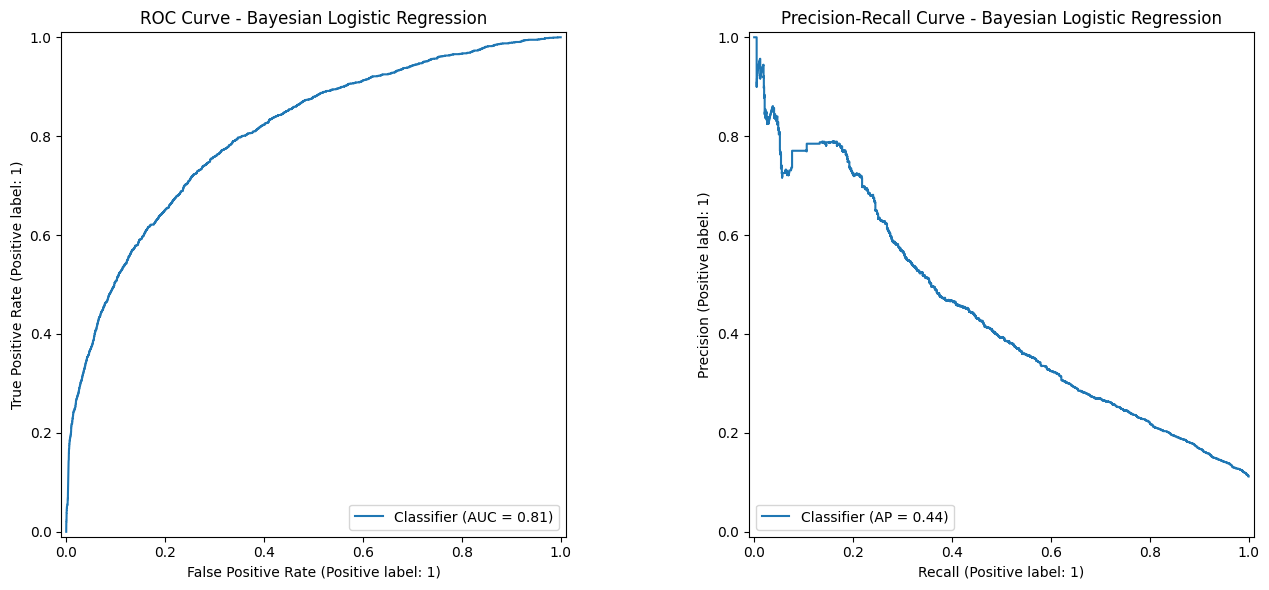

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

roc_display = RocCurveDisplay.from_predictions(y_test, mean_probs, ax=axes[0])
axes[0].set_title("ROC Curve - Bayesian Logistic Regression")

pr_display = PrecisionRecallDisplay.from_predictions(y_test, mean_probs, ax=axes[1])
axes[1].set_title("Precision-Recall Curve - Bayesian Logistic Regression")

plt.tight_layout()
plt.show()


Optimal threshold: 0.20
Precision at optimal threshold: 0.411
Recall at optimal threshold: 0.477
F1 at optimal threshold: 0.442


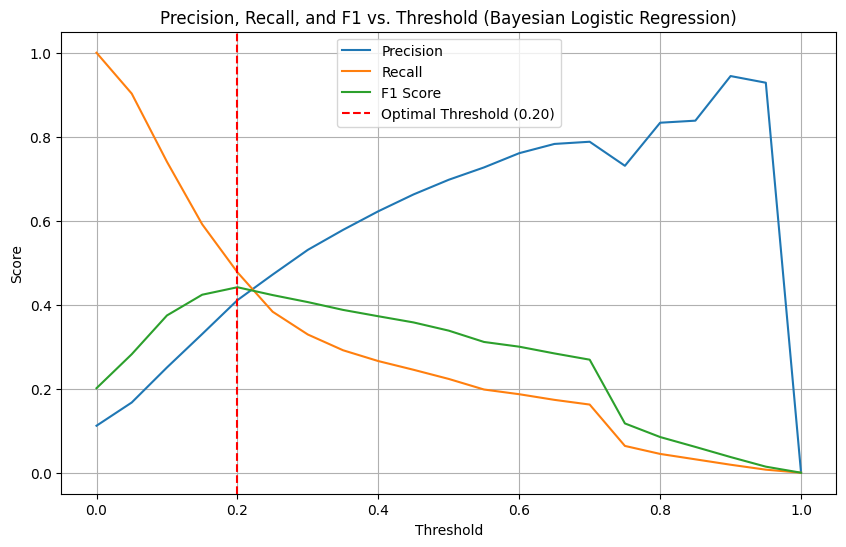

In [49]:
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.arange(0.0, 1.01, 0.05)
precisions, recalls, f1s = [], [], []

for t in thresholds:
    y_pred_thresh = (mean_probs >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred_thresh, zero_division=0))
    recalls.append(recall_score(y_test, y_pred_thresh, zero_division=0))
    f1s.append(f1_score(y_test, y_pred_thresh, zero_division=0))

optimal_idx = np.argmax(f1s)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.2f}")
print(f"Precision at optimal threshold: {precisions[optimal_idx]:.3f}")
print(f"Recall at optimal threshold: {recalls[optimal_idx]:.3f}")
print(f"F1 at optimal threshold: {f1s[optimal_idx]:.3f}")

# Plot threshold tuning curve
plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 vs. Threshold (Bayesian Logistic Regression)')
plt.legend()
plt.grid(True)
plt.show()


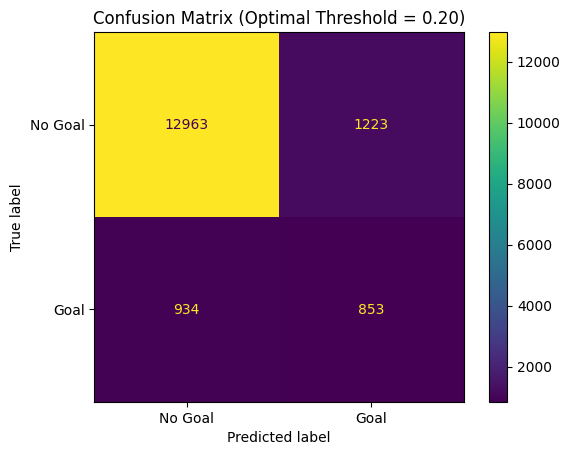

In [50]:
y_pred_optimal = (mean_probs >= optimal_threshold).astype(int)

cm_opt = confusion_matrix(y_test, y_pred_optimal)
disp_opt = ConfusionMatrixDisplay(confusion_matrix=cm_opt, display_labels=["No Goal", "Goal"])
disp_opt.plot(values_format='d')
plt.title(f"Confusion Matrix (Optimal Threshold = {optimal_threshold:.2f})")
plt.show()


In [51]:
import arviz as az

summary = az.summary(idata, var_names=["coeffs"], hdi_prob=0.95)

summary.index = feature_columns
summary.index.name = "Feature"

print(summary)

                          mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  \
Feature                                                                 
distance_to_goal        -0.890  0.033    -0.956     -0.829      0.001   
angle_to_goal_deg        0.412  0.021     0.369      0.455      0.000   
opponents_in_way        -0.426  0.021    -0.465     -0.384      0.000   
teammates_in_way         0.016  0.020    -0.021      0.055      0.000   
with_dominant_foot       0.025  0.015    -0.004      0.052      0.000   
shot_first_time          0.074  0.038    -0.005      0.148      0.001   
shot_one_on_one          0.274  0.051     0.167      0.367      0.001   
shot_open_goal           0.804  0.102     0.596      0.993      0.002   
technique_Backheel      -1.448  1.834    -4.930      2.086      0.099   
technique_Diving Header  0.843  1.834    -2.428      4.607      0.101   
technique_Half Volley   -0.397  1.829    -3.856      3.161      0.101   
technique_Lob            1.251  1.828    -1.987    

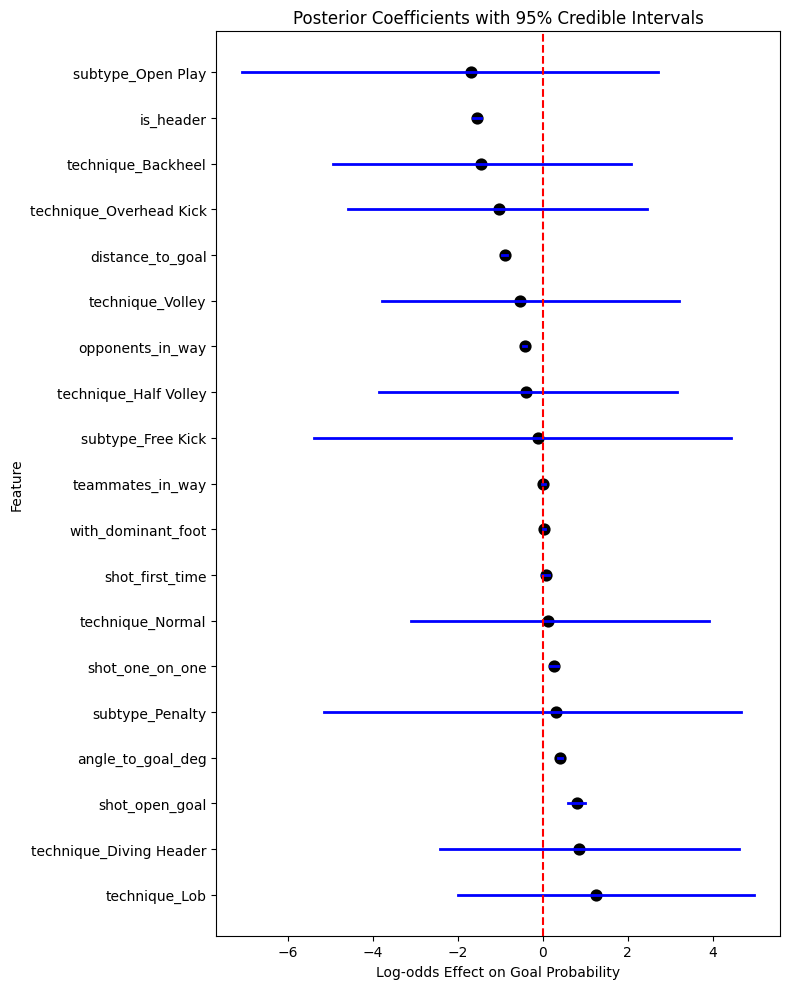

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

summary = az.summary(idata, var_names=["coeffs"], hdi_prob=0.95)
summary.index = feature_columns

summary = summary.sort_values("mean")

plt.figure(figsize=(8, 10))
sns.pointplot(
    x=summary["mean"],
    y=summary.index,
    join=False,
    color="black"
)

for i, (mean, low, high) in enumerate(zip(summary["mean"], summary["hdi_2.5%"], summary["hdi_97.5%"])):
    plt.plot([low, high], [i, i], color="blue", lw=2)

plt.axvline(0, color="red", linestyle="--")
plt.title("Posterior Coefficients with 95% Credible Intervals")
plt.xlabel("Log-odds Effect on Goal Probability")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


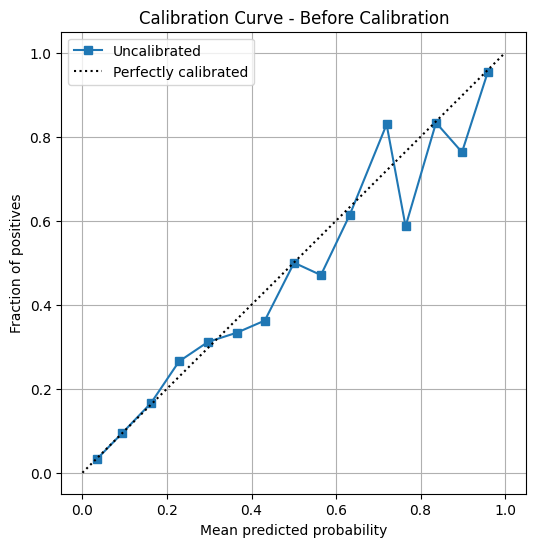

In [53]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, mean_probs, n_bins=15, strategy='uniform'
)

plt.figure(figsize=(6,6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Uncalibrated")
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve - Before Calibration")
plt.legend()
plt.grid(True)
plt.show()


In [54]:
from sklearn.linear_model import LogisticRegression

calibration_model = LogisticRegression()
calibration_model.fit(mean_probs.reshape(-1,1), y_test)

calibrated_probs = calibration_model.predict_proba(mean_probs.reshape(-1,1))[:,1]


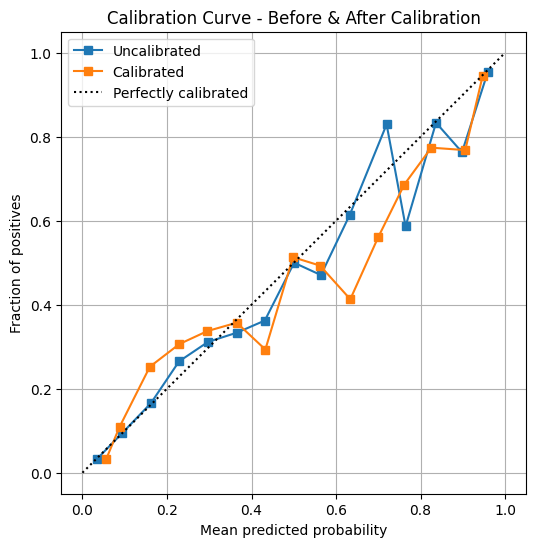

In [55]:
fraction_of_positives_cal, mean_predicted_value_cal = calibration_curve(
    y_test, calibrated_probs, n_bins=15, strategy='uniform'
)

plt.figure(figsize=(6,6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Uncalibrated")
plt.plot(mean_predicted_value_cal, fraction_of_positives_cal, "s-", label="Calibrated")
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve - Before & After Calibration")
plt.legend()
plt.grid(True)
plt.show()


In [56]:
blr_probs_before = mean_probs

blr_probs_after = calibrated_probs

In [57]:
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, brier_score_loss, average_precision_score

#Before calibration
y_pred = (mean_probs >= 0.5).astype(int)
auc = roc_auc_score(y_test, mean_probs)
acc = accuracy_score(y_test, y_pred)
ll = log_loss(y_test, mean_probs)
brier = brier_score_loss(y_test, mean_probs)
ap = average_precision_score(y_test, mean_probs)

print("Before calibration:")
print(f"AUC:       {auc:.3f}")
print(f"Accuracy:  {acc:.3f}")
print(f"Log-Loss:  {ll:.3f}")
print(f"Brier:     {brier:.3f}")
print(f"AP:        {ap:.3f}")

#After calibration
y_pred_cal = (calibrated_probs >= 0.5).astype(int)
auc_cal = roc_auc_score(y_test, calibrated_probs)
acc_cal = accuracy_score(y_test, y_pred_cal)
ll_cal = log_loss(y_test, calibrated_probs)
brier_cal = brier_score_loss(y_test, calibrated_probs)
ap_cal = average_precision_score(y_test, calibrated_probs)

print("\nAfter calibration:")
print(f"AUC:       {auc_cal:.3f}")
print(f"Accuracy:  {acc_cal:.3f}")
print(f"Log-Loss:  {ll_cal:.3f}")
print(f"Brier:     {brier_cal:.3f}")
print(f"AP:        {ap_cal:.3f}")


Before calibration:
AUC:       0.805
Accuracy:  0.902
Log-Loss:  0.277
Brier:     0.079
AP:        0.442

After calibration:
AUC:       0.805
Accuracy:  0.902
Log-Loss:  0.285
Brier:     0.081
AP:        0.442


Bayesian Neural Network

In [12]:
import pymc as pm
import numpy as np
import arviz as az
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')

X_train_bayes = X_train_scaled.astype(np.float32)
y_train_bayes = y_train.values.astype(np.int32)

n_features = X_train_bayes.shape[1]
n_hidden   = 5

with pm.Model() as bnn_small:

    w_hidden = pm.Normal("w_hidden", 0, 0.5, shape=(n_features, n_hidden))
    b_hidden = pm.Normal("b_hidden", 0, 0.5, shape=(n_hidden,))
    hidden   = pm.math.tanh(pm.math.dot(X_train_bayes, w_hidden) + b_hidden)

    w_out = pm.Normal("w_out", 0, 0.5, shape=(n_hidden,))
    b_out = pm.Normal("b_out", 0, 0.5)

    lin = pm.math.dot(hidden, w_out) + b_out
    p   = pm.Deterministic("p", pm.math.sigmoid(lin))

    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_train_bayes)

    trace_bnn_small = pm.sample(
        draws=400, tune=400,
        chains=2, cores=2,
        target_accept=0.9,
        return_inferencedata=True,
        progressbar=True,
        random_seed=42
    )

print(az.summary(trace_bnn_small, var_names=["w_out","b_out"], hdi_prob=0.95))


drive_path = "/content/drive/MyDrive/bnn_small_trace.nc"

az.to_netcdf(trace_bnn_small, drive_path)
print(f"Trace saved to Google Drive: {drive_path}")

local_path = "/content/bnn_small_trace.nc"
az.to_netcdf(trace_bnn_small, local_path)
files.download(local_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
w_out[0] -0.331  1.793    -2.496      1.748      1.248    0.014       3.0   
w_out[1]  0.021  0.979    -1.273      1.286      0.675    0.018       3.0   
w_out[2]  1.475  0.204     1.129      1.907      0.030    0.006      53.0   
w_out[3] -0.261  1.730    -2.295      1.766      1.205    0.008       3.0   
w_out[4]  1.203  0.157     0.909      1.510      0.008    0.006     438.0   
b_out    -0.418  0.227    -0.894      0.012      0.040    0.009      33.0   

          ess_tail  r_hat  
w_out[0]     167.0   1.84  
w_out[1]     133.0   1.83  
w_out[2]     305.0   1.05  
w_out[3]     185.0   1.83  
w_out[4]     453.0   1.00  
b_out        420.0   1.06  
Trace saved to Google Drive: /content/drive/MyDrive/bnn_small_trace.nc


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [61]:
!pip install gdown
import gdown
import arviz as az

file_id_bnn = '1cAIsGwtc0dUwTyPI_SFGUYSAok-bndm_'
gdown.download(f'https://drive.google.com/uc?id={file_id_bnn}', 'bnn_small_trace.nc', quiet=False)

trace_bnn_small = az.from_netcdf('bnn_small_trace.nc')
print("Trace loaded successfully!")

Downloading...
From (original): https://drive.google.com/uc?id=1cAIsGwtc0dUwTyPI_SFGUYSAok-bndm_
From (redirected): https://drive.google.com/uc?id=1cAIsGwtc0dUwTyPI_SFGUYSAok-bndm_&confirm=t&uuid=367287cf-284c-4989-8f14-80e2d172a925
To: /content/bnn_small_trace.nc
100%|██████████| 385M/385M [00:03<00:00, 96.6MB/s]


Trace loaded successfully!


BNN Small - AUC: 0.813, Accuracy: 0.904, Log-Loss: 0.271


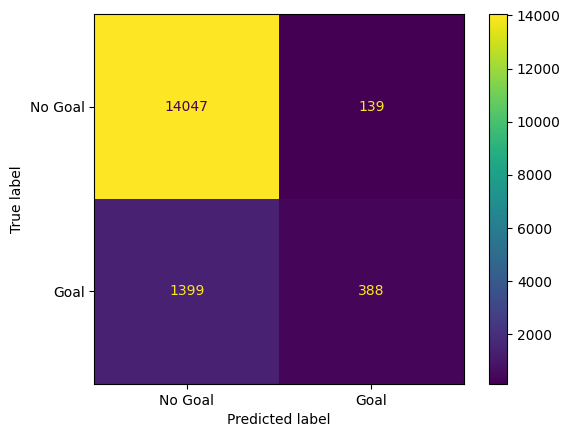

In [62]:
from scipy.special import expit
import numpy as np
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

X_test_bayes = X_test_scaled.astype(np.float32)

w_h = trace_bnn_small.posterior["w_hidden"].stack(s=("chain","draw")).values  # (F,H,S)
b_h = trace_bnn_small.posterior["b_hidden"].stack(s=("chain","draw")).values  # (H,S)
w_o = trace_bnn_small.posterior["w_out"].stack(s=("chain","draw")).values     # (H,S)
b_o = trace_bnn_small.posterior["b_out"].stack(s=("chain","draw")).values     # (S,)

S = w_h.shape[-1]
probs = np.empty((S, X_test_bayes.shape[0]), dtype=np.float32)

for i in range(S):
    hidden = np.tanh(X_test_bayes @ w_h[..., i] + b_h[..., i])
    lin    = hidden @ w_o[..., i] + b_o[i]
    probs[i, :] = expit(lin)

mean_probs = probs.mean(axis=0)

y_pred = (mean_probs >= 0.5).astype(int)

auc = roc_auc_score(y_test, mean_probs)
ll  = log_loss(y_test, mean_probs)
acc = accuracy_score(y_test, y_pred)

print(f"BNN Small - AUC: {auc:.3f}, Accuracy: {acc:.3f}, Log-Loss: {ll:.3f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Goal", "Goal"])
disp.plot(values_format='d')


Before calibration:
AUC:       0.813
Accuracy:  0.904
Log-Loss:  0.271
Brier:     0.077
AP:        0.467

After calibration:
AUC:       0.813
Accuracy:  0.904
Log-Loss:  0.277
Brier:     0.078
AP:        0.467


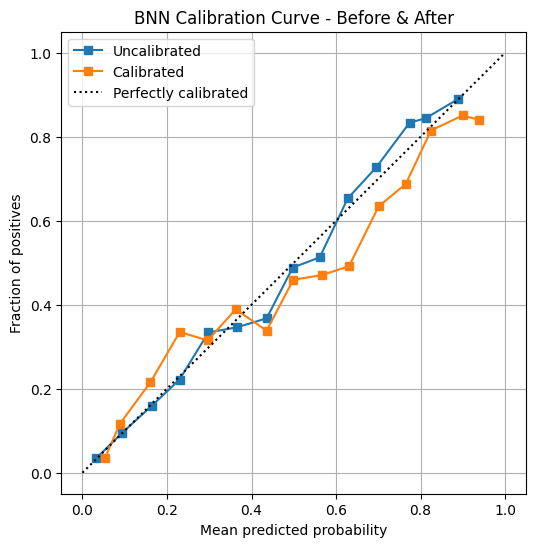

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    roc_auc_score, log_loss, accuracy_score, brier_score_loss,
    average_precision_score
)
import matplotlib.pyplot as plt

#Before calibration
auc = roc_auc_score(y_test, mean_probs)
acc = accuracy_score(y_test, (mean_probs >= 0.5).astype(int))
ll = log_loss(y_test, mean_probs)
brier = brier_score_loss(y_test, mean_probs)
ap = average_precision_score(y_test, mean_probs)

print("Before calibration:")
print(f"AUC:       {auc:.3f}")
print(f"Accuracy:  {acc:.3f}")
print(f"Log-Loss:  {ll:.3f}")
print(f"Brier:     {brier:.3f}")
print(f"AP:        {ap:.3f}")

#Calibration
calibration_model = LogisticRegression()
calibration_model.fit(mean_probs.reshape(-1, 1), y_test)
calibrated_probs = calibration_model.predict_proba(mean_probs.reshape(-1, 1))[:, 1]

#After calibration
auc_cal = roc_auc_score(y_test, calibrated_probs)
acc_cal = accuracy_score(y_test, (calibrated_probs >= 0.5).astype(int))
ll_cal = log_loss(y_test, calibrated_probs)
brier_cal = brier_score_loss(y_test, calibrated_probs)
ap_cal = average_precision_score(y_test, calibrated_probs)

print("\nAfter calibration:")
print(f"AUC:       {auc_cal:.3f}")
print(f"Accuracy:  {acc_cal:.3f}")
print(f"Log-Loss:  {ll_cal:.3f}")
print(f"Brier:     {brier_cal:.3f}")
print(f"AP:        {ap_cal:.3f}")

#Calibration curves
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, mean_probs, n_bins=15, strategy='uniform'
)

fraction_of_positives_cal, mean_predicted_value_cal = calibration_curve(
    y_test, calibrated_probs, n_bins=15, strategy='uniform'
)

plt.figure(figsize=(6, 6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Uncalibrated")
plt.plot(mean_predicted_value_cal, fraction_of_positives_cal, "s-", label="Calibrated")
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("BNN Calibration Curve - Before & After")
plt.legend()
plt.grid(True)
plt.show()


In [64]:
bnn_probs_before = mean_probs

bnn_probs_after = calibrated_probs

Additional Report Charts

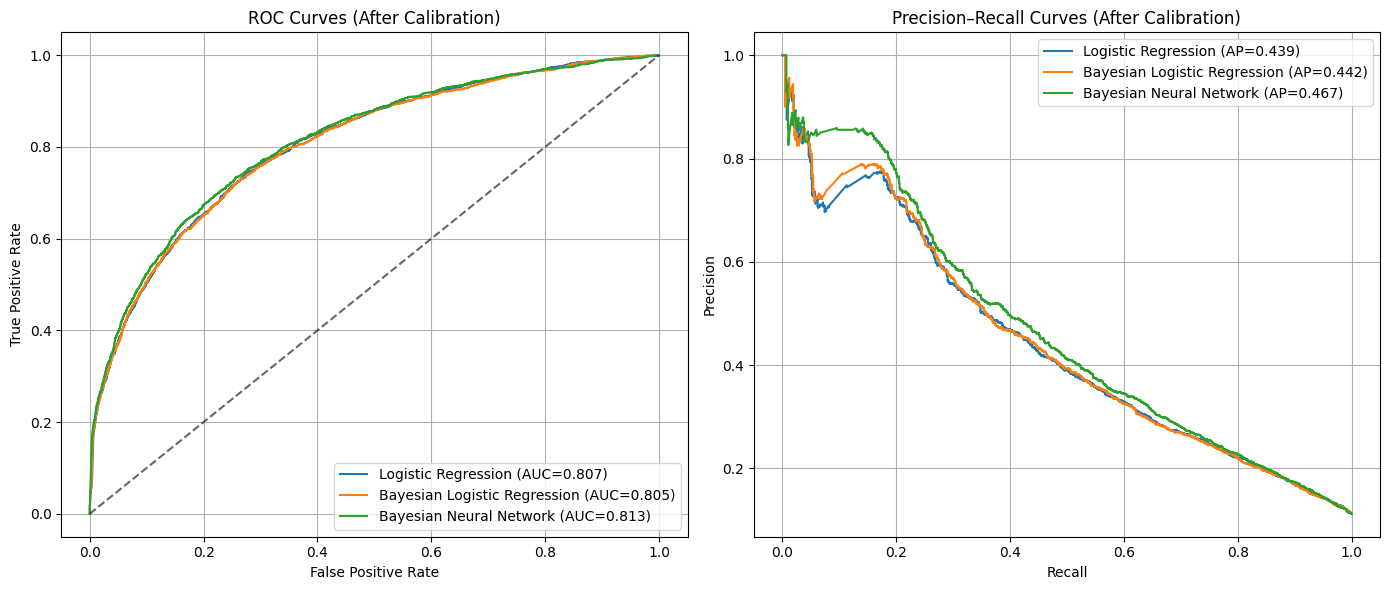

In [103]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax_roc = axes[0]
for model_name, (y_true, _, probs_after) in model_results.items():
    fpr, tpr, _ = roc_curve(y_true, probs_after)
    roc_auc = auc(fpr, tpr)
    ax_roc.plot(fpr, tpr, label=f"{model_name} (AUC={roc_auc:.3f})")

ax_roc.plot([0, 1], [0, 1], "k--", alpha=0.6)
ax_roc.set_title("ROC Curves (After Calibration)")
ax_roc.set_xlabel("False Positive Rate")
ax_roc.set_ylabel("True Positive Rate")
ax_roc.legend()
ax_roc.grid(True)

ax_pr = axes[1]
for model_name, (y_true, _, probs_after) in model_results.items():
    precision, recall, _ = precision_recall_curve(y_true, probs_after)
    ap = average_precision_score(y_true, probs_after)
    ax_pr.plot(recall, precision, label=f"{model_name} (AP={ap:.3f})")

ax_pr.set_title("Precision–Recall Curves (After Calibration)")
ax_pr.set_xlabel("Recall")
ax_pr.set_ylabel("Precision")
ax_pr.legend()
ax_pr.grid(True)

plt.tight_layout()
plt.show()


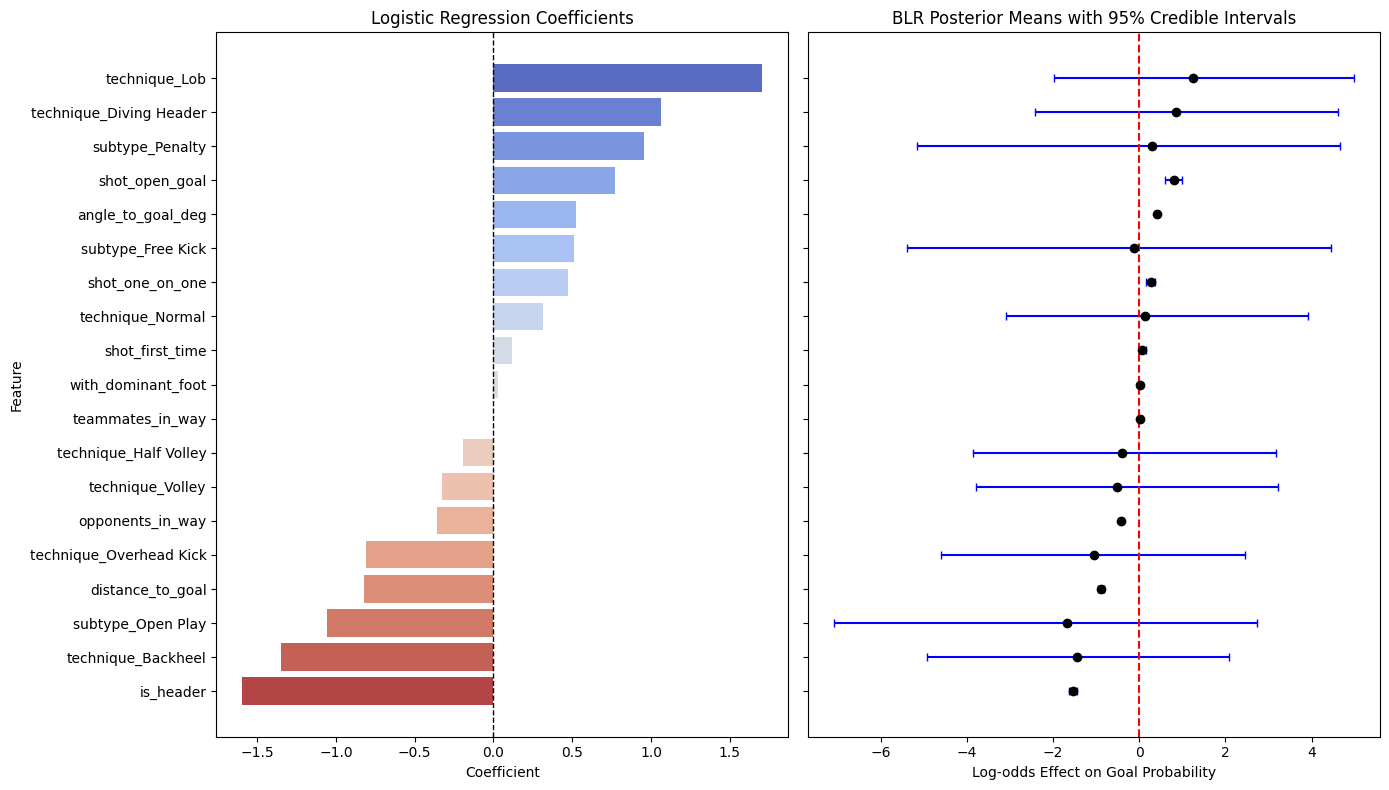

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az

lr_coefficients = pipeline_logistic.named_steps['classifier'].coef_[0]
coef_df_lr = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': lr_coefficients
}).sort_values(by='Coefficient', ascending=False)

summary_blr = az.summary(idata, var_names=["coeffs"], hdi_prob=0.95)
summary_blr.index = feature_columns
summary_blr = summary_blr.sort_values("mean", ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharey=True)

sns.barplot(
    data=coef_df_lr,
    x='Coefficient',
    y='Feature',
    palette='coolwarm',
    ax=axes[0]
)
axes[0].set_title("Logistic Regression Coefficients")
axes[0].axvline(0, color="black", linestyle="--", linewidth=1)

axes[1].errorbar(
    summary_blr["mean"],
    summary_blr.index,
    xerr=[
        summary_blr["mean"] - summary_blr["hdi_2.5%"],
        summary_blr["hdi_97.5%"] - summary_blr["mean"]
    ],
    fmt='o',
    color='black',
    ecolor='blue',
    capsize=3
)
axes[1].axvline(0, color="red", linestyle="--")
axes[1].set_title("BLR Posterior Means with 95% Credible Intervals")
axes[1].set_xlabel("Log-odds Effect on Goal Probability")

plt.tight_layout()
plt.show()

Uncertainty estimation

In [107]:
from scipy.special import expit
import numpy as np
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score

def predict_blr(trace, X_test):
    intercept_samples = trace.posterior["intercept"].stack(s=("chain", "draw")).values
    coeff_samples = trace.posterior["coeffs"].stack(s=("chain", "draw")).values
    linpreds = intercept_samples[:, None] + np.dot(coeff_samples.T, X_test.T)
    probs = expit(linpreds)
    return probs

def predict_bnn(trace, X_test):
    w_h = trace.posterior["w_hidden"].stack(s=("chain","draw")).values
    b_h = trace.posterior["b_hidden"].stack(s=("chain","draw")).values
    w_o = trace.posterior["w_out"].stack(s=("chain","draw")).values
    b_o = trace.posterior["b_out"].stack(s=("chain","draw")).values
    S = w_h.shape[-1]
    probs = np.empty((S, X_test.shape[0]), dtype=np.float32)
    for i in range(S):
        hidden = np.tanh(X_test @ w_h[..., i] + b_h[..., i])
        lin    = hidden @ w_o[..., i] + b_o[i]
        probs[i, :] = expit(lin)
    return probs


In [108]:
X_test_bayes = X_test_scaled.astype(np.float32)

# BLR
probs_blr = predict_blr(trace_blr, X_test_bayes)
mean_blr = probs_blr.mean(axis=0)
auc_blr = roc_auc_score(y_test, mean_blr)
acc_blr = accuracy_score(y_test, (mean_blr >= 0.5).astype(int))
ll_blr  = log_loss(y_test, mean_blr)

# BNN
probs_bnn = predict_bnn(trace_bnn_small, X_test_bayes)
mean_bnn = probs_bnn.mean(axis=0)
auc_bnn = roc_auc_score(y_test, mean_bnn)
acc_bnn = accuracy_score(y_test, (mean_bnn >= 0.5).astype(int))
ll_bnn  = log_loss(y_test, mean_bnn)

print(f"Bayesian Logistic Regression - AUC: {auc_blr:.3f}, Accuracy: {acc_blr:.3f}, Log-Loss: {ll_blr:.3f}")
print(f"Bayesian Neural Network      - AUC: {auc_bnn:.3f}, Accuracy: {acc_bnn:.3f}, Log-Loss: {ll_bnn:.3f}")


Bayesian Logistic Regression - AUC: 0.805, Accuracy: 0.902, Log-Loss: 0.277
Bayesian Neural Network      - AUC: 0.813, Accuracy: 0.904, Log-Loss: 0.271


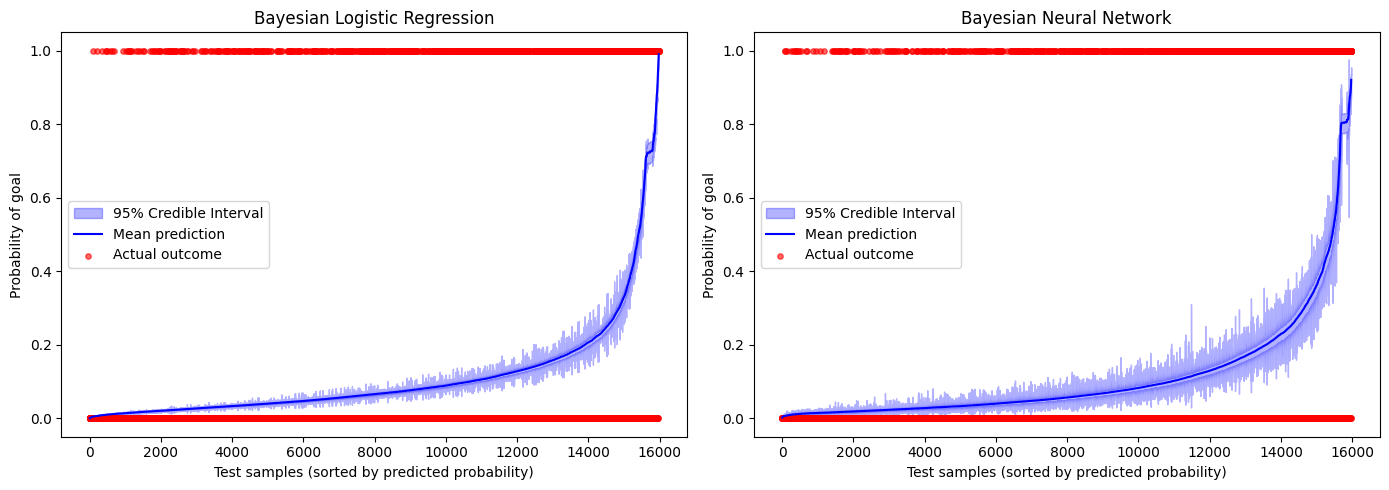

In [109]:
import matplotlib.pyplot as plt

def plot_uncertainty(probs, mean_probs, y_test, title):
    lower = np.percentile(probs, 2.5, axis=0)
    upper = np.percentile(probs, 97.5, axis=0)
    sorted_idx = np.argsort(mean_probs)
    plt.fill_between(range(len(mean_probs)), lower[sorted_idx], upper[sorted_idx], alpha=0.3, color="blue", label="95% Credible Interval")
    plt.plot(mean_probs[sorted_idx], color="blue", label="Mean prediction")
    plt.scatter(range(len(mean_probs)), y_test.values[sorted_idx], color="red", s=15, alpha=0.6, label="Actual outcome")
    plt.xlabel("Test samples (sorted by predicted probability)")
    plt.ylabel("Probability of goal")
    plt.title(title)
    plt.legend()

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plot_uncertainty(probs_blr, mean_blr, y_test, "Bayesian Logistic Regression")

plt.subplot(1, 2, 2)
plot_uncertainty(probs_bnn, mean_bnn, y_test, "Bayesian Neural Network")

plt.tight_layout()
plt.show()



=== Bayesian Logistic Regression ===
Mean predictive std: 0.004
Median predictive std: 0.003
Std deviation range: 0.000 - 0.049
25th percentile: 0.002
75th percentile: 0.005

=== Bayesian Neural Network ===
Mean predictive std: 0.008
Median predictive std: 0.006
Std deviation range: 0.001 - 0.115
25th percentile: 0.003
75th percentile: 0.011


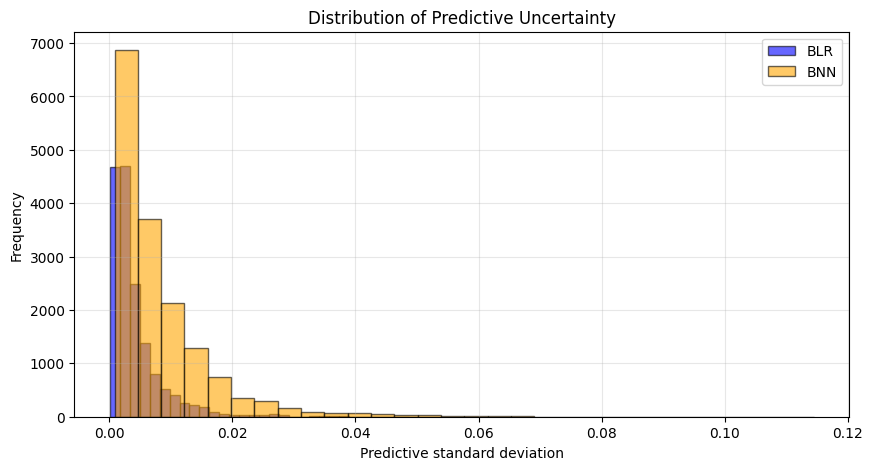


=== BLR - Least Uncertain ===
   Predicted Prob  True Outcome  Uncertainty
0        0.000317             0     0.000062
1        0.000330             0     0.000063
2        0.000395             0     0.000068

=== BLR - Most Uncertain ===
   Predicted Prob  True Outcome  Uncertainty
0        0.531413             1     0.047234
1        0.289284             1     0.047850
2        0.304272             0     0.048717

=== BNN - Least Uncertain ===
   Predicted Prob  True Outcome  Uncertainty
0        0.002060             0     0.000858
1        0.004660             0     0.000961
2        0.003207             0     0.001002

=== BNN - Most Uncertain ===
   Predicted Prob  True Outcome  Uncertainty
0        0.692616             1     0.089503
1        0.504921             1     0.105039
2        0.837587             1     0.114527


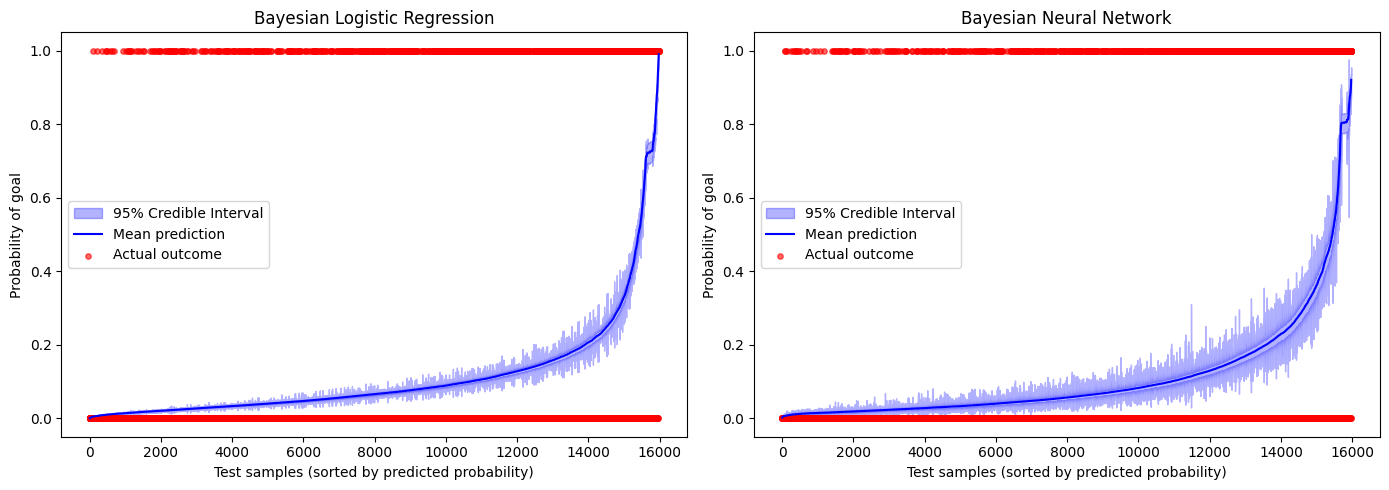

In [110]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

std_blr = probs_blr.std(axis=0)
std_bnn = probs_bnn.std(axis=0)

def summarize_uncertainty(std_values, model_name):
    print(f"\n=== {model_name} ===")
    print(f"Mean predictive std: {std_values.mean():.3f}")
    print(f"Median predictive std: {np.median(std_values):.3f}")
    print(f"Std deviation range: {std_values.min():.3f} - {std_values.max():.3f}")
    print(f"25th percentile: {np.percentile(std_values, 25):.3f}")
    print(f"75th percentile: {np.percentile(std_values, 75):.3f}")

summarize_uncertainty(std_blr, "Bayesian Logistic Regression")
summarize_uncertainty(std_bnn, "Bayesian Neural Network")

plt.figure(figsize=(10,5))
plt.hist(std_blr, bins=30, alpha=0.6, label="BLR", color='blue', edgecolor='black')
plt.hist(std_bnn, bins=30, alpha=0.6, label="BNN", color='orange', edgecolor='black')
plt.xlabel("Predictive standard deviation")
plt.ylabel("Frequency")
plt.title("Distribution of Predictive Uncertainty")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


def extreme_examples(std_values, mean_probs, y_true, top_n=3):
    sorted_idx = np.argsort(std_values)  # ascending
    least_uncertain = sorted_idx[:top_n]
    most_uncertain = sorted_idx[-top_n:]

    df_least = pd.DataFrame({
        "Predicted Prob": mean_probs[least_uncertain],
        "True Outcome": y_true.values[least_uncertain],
        "Uncertainty": std_values[least_uncertain]
    })

    df_most = pd.DataFrame({
        "Predicted Prob": mean_probs[most_uncertain],
        "True Outcome": y_true.values[most_uncertain],
        "Uncertainty": std_values[most_uncertain]
    })

    return df_least, df_most

blr_least, blr_most = extreme_examples(std_blr, mean_blr, y_test)
bnn_least, bnn_most = extreme_examples(std_bnn, mean_bnn, y_test)

print("\n=== BLR - Least Uncertain ===")
print(blr_least)
print("\n=== BLR - Most Uncertain ===")
print(blr_most)

print("\n=== BNN - Least Uncertain ===")
print(bnn_least)
print("\n=== BNN - Most Uncertain ===")
print(bnn_most)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plot_uncertainty(probs_blr, mean_blr, y_test, "Bayesian Logistic Regression")

plt.subplot(1, 2, 2)
plot_uncertainty(probs_bnn, mean_bnn, y_test, "Bayesian Neural Network")

plt.tight_layout()
plt.show()
